# Predicting severity of collisions


This notebook analyzes of a data set containing car accidents in the city of Seattle. This report presents a visualization of the data and a model to predict the severity of the accidents depending on certain conditions.

DATASET:

Title: Collisions (2004 to present)
Abstract: All collisions provided by SPD and recorded by Traffic Records.
Contact email: DOT_IT_GIS@seattle.gov


Loading the necessary libraries

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Reading the dataset

In [23]:
Collisions = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv', low_memory = False)

Having a first look of the dataset

In [37]:
Collisions['SEVERITYCODE.1']

0         2
1         1
2         1
3         1
4         2
         ..
194668    2
194669    1
194670    2
194671    2
194672    1
Name: SEVERITYCODE.1, Length: 194673, dtype: int64

## Data understanding

An initial analysis of the data to see the format a number of attibutes:

In [25]:
Collisions.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [26]:
Collisions.shape

(194673, 38)

A correlation matrix helps to identify redundant information e.g. "COLDETKEY" and "INTKEY" are highly correlated, therefore we need just one of these features.

In [27]:
Collisions.corr(method='pearson', min_periods=1)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
SEVERITYCODE,1.000000,0.010309,0.017737,0.020131,0.022065,0.022079,0.006553,1.000000,0.130949,0.246338,0.214218,-0.054686,0.188905,0.004226,0.104276,0.175093
X,0.010309,1.000000,-0.160262,0.009956,0.010309,0.010300,0.120754,0.010309,0.012887,0.011304,-0.001752,-0.012168,0.010904,-0.001016,-0.001618,0.013586
Y,0.017737,-0.160262,1.000000,-0.023848,-0.027396,-0.027415,-0.114935,0.017737,-0.013850,0.010178,0.026304,0.017058,-0.019694,-0.006958,0.004618,0.009508
OBJECTID,0.020131,0.009956,-0.023848,1.000000,0.946383,0.945837,0.046929,0.020131,-0.062333,0.024604,0.034432,-0.094280,-0.037094,0.969276,0.028076,0.056046
INCKEY,0.022065,0.010309,-0.027396,0.946383,1.000000,0.999996,0.048524,0.022065,-0.061500,0.024918,0.031342,-0.107528,-0.027617,0.990571,0.019701,0.048179
COLDETKEY,0.022079,0.010300,-0.027415,0.945837,0.999996,1.000000,0.048499,0.022079,-0.061403,0.024914,0.031296,-0.107598,-0.027461,0.990571,0.019586,0.048063
INTKEY,0.006553,0.120754,-0.114935,0.046929,0.048524,0.048499,1.000000,0.006553,0.001886,-0.004784,0.000531,-0.012929,0.007114,0.032604,-0.010510,0.018420
SEVERITYCODE.1,1.000000,0.010309,0.017737,0.020131,0.022065,0.022079,0.006553,1.000000,0.130949,0.246338,0.214218,-0.054686,0.188905,0.004226,0.104276,0.175093
PERSONCOUNT,0.130949,0.012887,-0.013850,-0.062333,-0.061500,-0.061403,0.001886,0.130949,1.000000,-0.023464,-0.038809,0.380523,-0.128960,0.011784,-0.021383,-0.032258
PEDCOUNT,0.246338,0.011304,0.010178,0.024604,0.024918,0.024914,-0.004784,0.246338,-0.023464,1.000000,-0.016920,-0.261285,0.260393,0.021461,0.001810,0.565326


## Data preparation

### Initial data visualization

The first step before start targeting attributes and cleaning the data is a short visualization

In [38]:
ADDRTYPE_Count = Collisions['ADDRTYPE'].value_counts()
print(ADDRTYPE_Count)

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64


In [39]:
SEVERITY_Count = Collisions['SEVERITYCODE'].value_counts()
print(SEVERITY_Count)

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64


Number of collisions in time

In [48]:
INCDATE = Collisions.groupby(['INCDATE'])['SEVERITYCODE'].count().reset_index()
print(INCDATE)

                     INCDATE  SEVERITYCODE
0     2004/01/01 00:00:00+00            25
1     2004/01/02 00:00:00+00            64
2     2004/01/03 00:00:00+00            20
3     2004/01/04 00:00:00+00            14
4     2004/01/05 00:00:00+00            18
...                      ...           ...
5980  2020/05/16 00:00:00+00             5
5981  2020/05/17 00:00:00+00             1
5982  2020/05/18 00:00:00+00             2
5983  2020/05/19 00:00:00+00             1
5984  2020/05/20 00:00:00+00             1

[5985 rows x 2 columns]


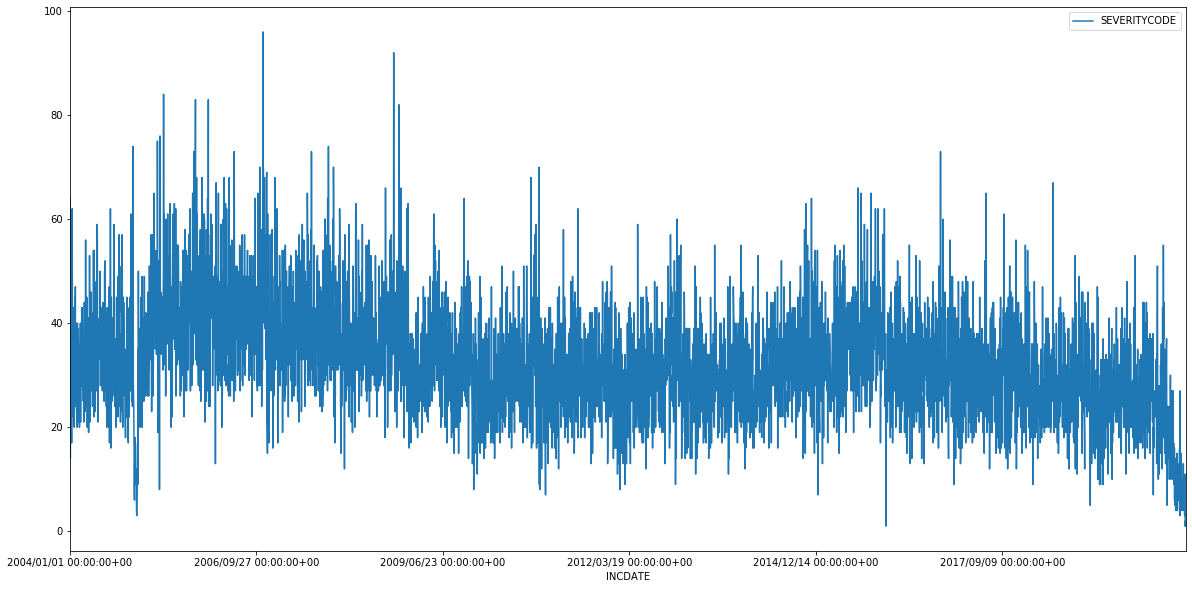

In [56]:
INCDATE.plot(x='INCDATE', y='SEVERITYCODE', figsize=(20, 10))

## Data preparation

From the data description I choose the features that may be used for a classification. In this study I will mainly focus on numerical features or features that can be converted to a numerical. The other I will dismiss for the purpose of the classification.

I have focused on three specific attributes that describe the conditions when a collision occured: WEATHER, ROADCOND, LIGHTCOND

In [57]:
Collisions_red = Collisions.drop(['OBJECTID', 'INCKEY', 'COLDETKEY', 'ADDRTYPE', 'LOCATION','EXCEPTRSNCODE','EXCEPTRSNDESC', 'SEVERITYCODE.1','SEVERITYDESC','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','REPORTNO','INCDATE','INCDTTM','INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','HITPARKEDCAR','SDOT_COLCODE','SDOT_COLDESC','STATUS','SDOTCOLNUM','CROSSWALKKEY','ST_COLCODE','ST_COLDESC','SEGLANEKEY','SPEEDING','INTKEY','JUNCTIONTYPE'], axis=1)

In [58]:
Collisions_red.head(15)

,SEVERITYCODE,X,Y,WEATHER,ROADCOND,LIGHTCOND
0,2,-122.323148,47.703140,Overcast,Wet,Daylight
1,1,-122.347294,47.647172,Raining,Wet,Dark - Street Lights On
2,1,-122.334540,47.607871,Overcast,Dry,Daylight
3,1,-122.334803,47.604803,Clear,Dry,Daylight
4,2,-122.306426,47.545739,Raining,Wet,Daylight
5,1,-122.387598,47.690575,Clear,Dry,Daylight
6,1,-122.338485,47.618534,Raining,Wet,Daylight
7,2,-122.320780,47.614076,Clear,Dry,Daylight
8,1,-122.335930,47.611904,Clear,Dry,Daylight
9,2,-122.384700,47.528475,Clear,Dry,Daylight


In [59]:
Collisions_red.dtypes

SEVERITYCODE      int64
X               float64
Y               float64
WEATHER          object
ROADCOND         object
LIGHTCOND        object
dtype: object

### Cleaning

I am going to remove all the rows having missing/NaN data

In [60]:
Collisions_red.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
Collisions_red

,SEVERITYCODE,X,Y,WEATHER,ROADCOND,LIGHTCOND
0,2,-122.323148,47.703140,Overcast,Wet,Daylight
1,1,-122.347294,47.647172,Raining,Wet,Dark - Street Lights On
2,1,-122.334540,47.607871,Overcast,Dry,Daylight
3,1,-122.334803,47.604803,Clear,Dry,Daylight
4,2,-122.306426,47.545739,Raining,Wet,Daylight
...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,Clear,Dry,Daylight
194669,1,-122.344526,47.690924,Raining,Wet,Daylight
194670,2,-122.306689,47.683047,Clear,Dry,Daylight
194671,2,-122.355317,47.678734,Clear,Dry,Dusk


## Tranforming data

To be able to use this data for the classification process I assigning numerical coding to the attributes WEATHER, ROADCOND and LIGHTCOND

In [62]:
weather = {'Overcast': 0, 'Raining': 1, 'Clear': 3,'Unknown': 4,'Snowing': 5,'Fog/Smog/Smoke': 6, 'Sleet/Hail/Freezing Rain': 7, 'Blowing Sand/Dirt': 8,
       'Severe Crosswind': 9, 'Partly Cloudy': 10, 'Other': 11}
#Assign these different key-value pair from above dictiionary to your table
Collisions_red.WEATHER = [weather[item] for item in Collisions_red.WEATHER]
#New table
#Collisions_red.head()

In [63]:
condition = {'Wet': 0, 'Dry': 1, 'Unknown': 3,'Snow/Slush': 4,'Ice': 5,'Other': 6, 'Sand/Mud/Dirt': 7, 'Standing Water': 8,
       'Oil': 9}
Collisions_red.ROADCOND = [condition[item] for item in Collisions_red.ROADCOND]

In [64]:
light = {'Daylight': 0, 'Dark - Street Lights On': 1, 'Dark - No Street Lights': 2,
       'Unknown': 3, 'Dusk': 4, 'Dawn': 5, 'Dark - Street Lights Off': 6, 'Other': 7,
       'Dark - Unknown Lighting': 8}
Collisions_red.LIGHTCOND = [light[item] for item in Collisions_red.LIGHTCOND]

In [66]:
Collisions_red.head()

,SEVERITYCODE,X,Y,WEATHER,ROADCOND,LIGHTCOND
0,2,-122.323148,47.703140,0,0,0
1,1,-122.347294,47.647172,1,0,1
2,1,-122.334540,47.607871,0,1,0
3,1,-122.334803,47.604803,3,1,0
4,2,-122.306426,47.545739,1,0,0


# MODEL

For the model I will the scikit-learn library. The approach will be the KNN (K- Nearest Neighbor)
To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

In [67]:
X = Collisions_red[['WEATHER', 'ROADCOND','LIGHTCOND']] .values  #.astype(float)
X[0:5]

array([[0, 0, 0],
       [1, 0, 1],
       [0, 1, 0],
       [3, 1, 0],
       [1, 0, 0]])

SEVERITYCODE is define as the target label

In [97]:
y = Collisions_red['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2])

## Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:

In [99]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-1.65780552, -1.0852763 , -0.58058129],
       [-0.95021877, -1.0852763 ,  0.23666739],
       [-1.65780552,  0.05364787, -0.58058129],
       [ 0.46495473,  0.05364787, -0.58058129],
       [-0.95021877, -1.0852763 , -0.58058129]])

### Train Test Split  

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (147333, 3) (147333,)
Test set: (36834, 3) (36834,)


## Classification

In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [111]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [112]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([1, 1, 2, 1, 1])

In [113]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6669856719132848
Test set Accuracy:  0.6672910897540316


## Map visualization

In [69]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

# All requested packages already installed.



In [70]:
Lat = 47.6
Lon = -122.32

In [71]:
Seattle = folium.Map(location=[Lat, Lon], zoom_start=11)
Seattle

In [72]:
Collisions_red.shape

(184167, 6)

In [73]:
# get the first 200 accidents 
limit = 500
Collisions_red_500 = Collisions_red.iloc[0:limit, :]

In [74]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(Collisions_red_500.Y, Collisions_red_500.X):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Seattle.add_child(incidents)